In [1]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil
#sns.set(color_codes=True)

# load data
tmp_dir = "./cancell_tmp_csv/"
years = [str(year) for year in range(1994,2001)]
years.extend([str(year) for year in range(2002,2009)])
#years = [str(year) for year in range(2004,2005)]
#years=['2004']

## Procesar datos

In [2]:
#crear directorio con data de delays agrupada por retraso 

def read_df_from_csv(years):
    res = {}
    for year in years:

        print("Leyendo csv de año: {}".format(year))
        t=time.time()
        df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                         usecols=["Month", "Year", "DayofMonth", "DayOfWeek"] \
                         + ["ArrDelay", "DepDelay", "WeatherDelay", "CarrierDelay"] \
                         + ["ArrTime"] \
                         + ["Cancelled", "CancellationCode"] \
                         + ["NASDelay", "LateAircraftDelay"], \
                         encoding="ISO 8859-1")
        res[year] = df
        print("Listo - elapse: {}s".format(time.time() - t))

    return res

df_by_years = read_df_from_csv(years)

Leyendo csv de año: 1994


Listo - elapse: 15.03819990158081s
Leyendo csv de año: 1995


Listo - elapse: 16.891139268875122s
Leyendo csv de año: 1996


Listo - elapse: 17.01481580734253s
Leyendo csv de año: 1997


Listo - elapse: 17.16657257080078s
Leyendo csv de año: 1998


Listo - elapse: 17.117235898971558s
Leyendo csv de año: 1999


Listo - elapse: 17.932605028152466s
Leyendo csv de año: 2000


Listo - elapse: 18.5300714969635s
Leyendo csv de año: 2002


Listo - elapse: 17.320818185806274s
Leyendo csv de año: 2003


/usr/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Listo - elapse: 21.18009901046753s
Leyendo csv de año: 2004


Listo - elapse: 23.559237718582153s
Leyendo csv de año: 2005


Listo - elapse: 23.6472384929657s
Leyendo csv de año: 2006


Listo - elapse: 24.10122323036194s
Leyendo csv de año: 2007


Listo - elapse: 25.373400926589966s
Leyendo csv de año: 2008


Listo - elapse: 24.42020058631897s


In [3]:
# tipos de cancelamiento
CCarrier  = "A"
CWeather  = "B"
CNAS      = "C"
CSecurity = "D"

# frequency = 'D' (diario) o 'M' (mensual)
def create_grouped_files(df_csv: dict, subdir, years, frequency):
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    if not os.path.exists(tmp_dir + subdir):
        os.makedirs(tmp_dir + subdir)
    else:
        return

    df_cut = pd.DataFrame(columns=["date", "ArrDelay"]).set_index("date")
    df_full = pd.DataFrame(columns=["date", "ArrDelay"]).set_index("date")
    df_full_cancell = pd.DataFrame(columns=["date", "Cancelled"]).set_index("date")
    df_cut_cancell  = pd.DataFrame(columns=["date", "Cancelled"]).set_index("date")
    for year in years:
        if not os.path.exists(tmp_dir+subdir+year+".csv"):

            print("levantando año {}".format(year))

            df = df_csv[year].copy()

            #formato mas feliz para fechas
            if frequency == 'H':
                print(df.size)
                print("filtrando {} filas de NaN ".format(df.size))
                df.dropna(inplace=True)
                print("filas que quedan: {}".format(df.size))
                dates = pd.to_datetime(df.Year*1e8 + df.Month*1e6 + df.DayofMonth*1e4 + df.ArrTime.astype('int32')
                                       , format='%Y%m%d%H%M')
                print("----")
                print(df.size)
            else:
                dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth, format='%Y%m%d')

            df["date"] = dates.values
            df.set_index("date")

            #acumulamos en full antes de recortar outliers
            df_cancell = df[["date", "Cancelled", "CancellationCode"]]
            df = df[["date", "ArrDelay"]]

            dg = df.groupby(pd.Grouper(key='date', freq=frequency)).mean()
            df_full = pd.concat([df_full, dg], sort=False)

            # que las cancelaciones no sean por clima o seguridad
            df_cancell = df_cancell[(df_cancell['CancellationCode'] != CSecurity) & (df_cancell['CancellationCode'] != CWeather)]
            # y me quedo solo con el cancelled
            df_cancell = df_cancell[["date", "Cancelled"]]

            dg_cancell = df_cancell.groupby(pd.Grouper(key='date', freq=frequency)).sum()
            df_full_cancell = pd.concat([df_full_cancell, dg_cancell], sort=False)

            #sacamos outliers, nos quedamos con el 80% per bucket
            low = 0
            high = 1


            print("----------^^^-----------")
            #df_cancell.set_index('date')
            #df.set_index('date')

            print("sacando outliers de delays")
            qiles = df.groupby(pd.Grouper(key='date', freq=frequency))["ArrDelay"].quantile([low, high]).unstack(level=1)
            mask =  (qiles.loc[df.date, low] < df.ArrDelay.values) & \
                (df.ArrDelay.values < qiles.loc[df.date, high])
            df = df.loc[mask.values]

            #print("sacando outliers de cancelados")
            #print(df_cancell)
            #print(df_cancell["Cancelled"])
            #df_cancell = df_cancell.groupby(pd.Grouper(key='date', freq=frequency))
            #low_quantile   = df_cancell["Cancelled"].quantile(low)
            #high_quantile = df_cancell["Cancelled"].quantile(high)
            #print("low: {} high: {}".format(low_quantile, high_quantile))
            #df_cancell = df_cancell.apply(lambda x :
            #                              x[(x["Cancelled"] >= low_quantile) & \
            #                                (x["Cancelled"] <= high_quantile)]\
            #                              .sum()).reset_index()

            #qiles = df_cancell.groupby(pd.Grouper(key='date', freq=frequency))["Cancelled"].quantile([low, high]).unstack(level=1)
            #mask =  (qiles.loc[df_cancell.date, low] < df_cancell.Cancelled.values) & \
            #    (df_cancell.Cancelled.values < qiles.loc[df_cancell.date, high])
            #df_cancell = df_cancell.loc[mask.values] #TODO: esto falla!
            #print(df_cancell)

            #agrupamos luego de sacar outliers
            df_delay   = df.groupby(by=df['date'].dt.date).mean()
            df_cancell = dg_cancell

            df_delay.to_csv(tmp_dir+subdir+year+".csv")
            df_cancell.to_csv(tmp_dir+subdir+year+"_cancell.csv")

            df_cut         = pd.concat([df_cut, df_delay], sort=False)
            df_cut_cancell = pd.concat([df_cut_cancell, df_cancell], sort=False)
            del df_delay
            del df_cancell

    df_cut.to_csv(tmp_dir+subdir+"cut"+".csv")
    df_cut_cancell.to_csv(tmp_dir+subdir+"cut_cancell"+".csv")
    df_full.to_csv(tmp_dir+subdir+"full"+".csv")
    df_full_cancell.to_csv(tmp_dir+subdir+"full_cancell"+".csv")

create_grouped_files(df_by_years, "daily/", years, 'D')
print("Listo ./{}/daily/".format(tmp_dir))
create_grouped_files(df_by_years, "monthly/", years, 'M')
print("Listo ./{}/monthly/".format(tmp_dir))
#create_grouped_files(df_by_years, "hourly/", years, 'H')
#print("Listo ./tmp_csv/hourly/")

Listo ./tmp_csv/daily/
Listo ./tmp_csv/monthly/


# Vemos si hay alguna correlación entre ArrDelay y Cancelados

### primero vemos la matriz de correlación moviendo los periodos

In [4]:
import seaborn as sns

def get_file_names(periodo):
    fs=[]
    for filename in sorted(os.listdir(tmp_dir+periodo)):
        if filename.endswith(".csv") and not filename.endswith("_cancell.csv") and filename not in ["cut.csv"]:
            fs.append((filename, periodo))
    return fs

def correlation_table(file_periodo : tuple):

    filename, periodo = file_periodo

    df_delay   = pd.read_csv(tmp_dir+periodo+filename)
    df_cancell = pd.read_csv(tmp_dir+periodo+filename.split(".")[0]+"_cancell.csv")

    df = df_delay.merge(df_cancell, left_on='date', right_on='date')
    df["Cancelled-1"] = df["Cancelled"].shift(1)
    df["Cancelled-2"] = df["Cancelled"].shift(2)

    df["Cancelled+1"] = df["Cancelled"].shift(-1)
    df["Cancelled+2"] = df["Cancelled"].shift(-2)

    #print(df.head())

    corr=df.corr()
    #print(filename)
    #print(corr)
    #print("----")
    cm = sns.light_palette("green", as_cmap=True)
    cm = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    return corr.style.background_gradient(cmap=cm).set_precision(2)

import imgkit
def save_table_as_image(files):
    for f in files:
        fname, per = f
        per = per.replace('/', '')
        out="{}-{}-correlation-table.jpg".format(per,fname)
        print(out)
        imgkit.from_string(correlation_table(f).render(), out)

files = get_file_names("daily/")
correlation_table(files[0])
save_table_as_image(files)

files = get_file_names("monthly/")
correlation_table(files[0])
save_table_as_image(files)


daily-1994.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-1995.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-1996.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-1997.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-1998.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-1999.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-2000.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-2002.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-2003.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-2004.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-2005.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-2006.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-2007.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-2008.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
daily-full.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-1994.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-1995.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-1996.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-1997.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-1998.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-1999.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-2000.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-2002.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-2003.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-2004.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-2005.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-2006.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-2007.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-2008.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
monthly-full.csv-correlation-table.jpg


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


### luego tomamos algún shift y hacemos la regresión



In [5]:
def nrmse(y_true, y_pred):
    '''
    Devuelve el _Normalized Root Mean Square Error_ (NRMSE) entre `y_true` y
    `y_pred`.
    '''
    y_min = y_true.min()
    y_max = y_true.max()
    y_span = y_max - y_min

    mse = mean_squared_error(y_true, y_pred)

    return np.sqrt( mse / y_span**2 )

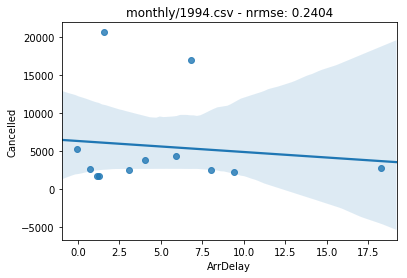

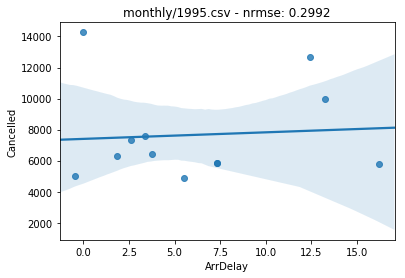

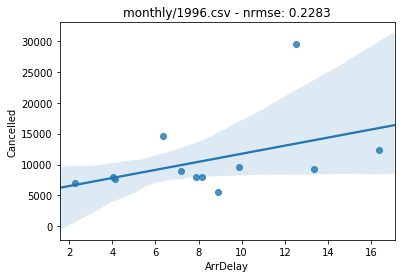

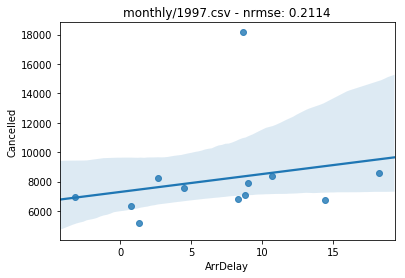

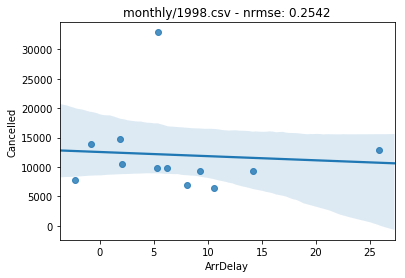

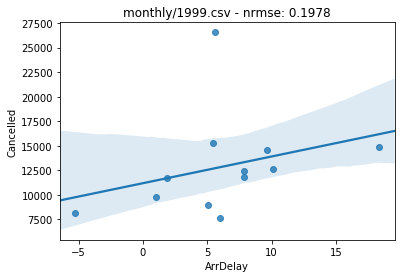

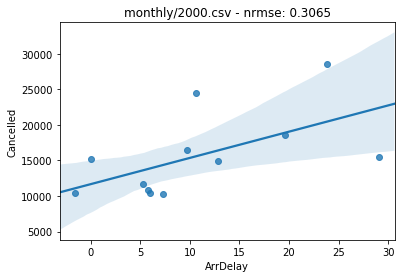

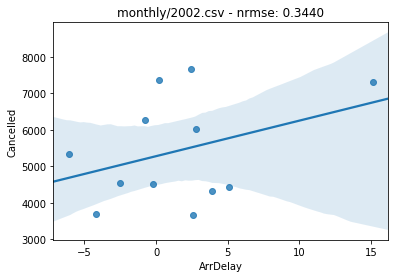

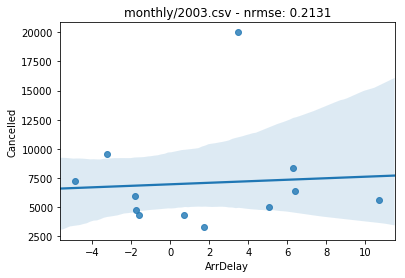

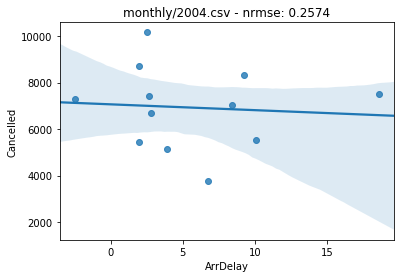

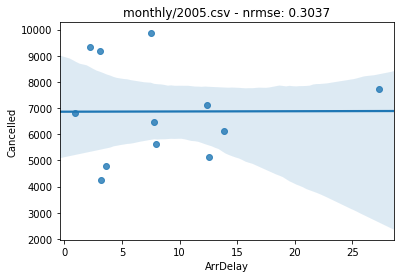

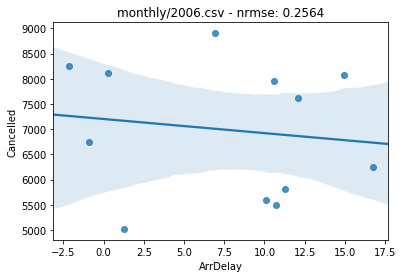

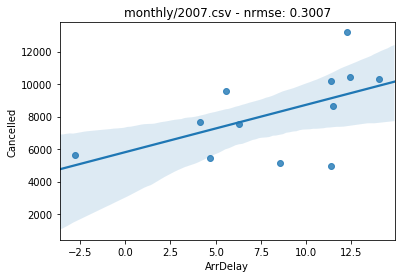

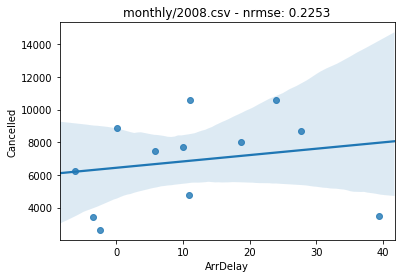

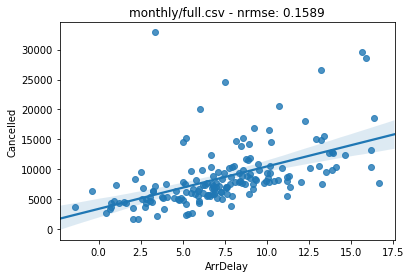

In [38]:
from cml import *
import numpy as np

def plot_correlation(file_periodo : tuple):
    filename, periodo = file_periodo

    df_delay   = pd.read_csv(tmp_dir+periodo+filename)
    df_cancell = pd.read_csv(tmp_dir+periodo+filename.split(".")[0]+"_cancell.csv")

    df = df_delay.merge(df_cancell, left_on='date', right_on='date')

    lr = LinealRegression()
    lr.fit(lr.get_x_vals(df['ArrDelay']), df['Cancelled'])

    sns.regplot(x="ArrDelay", y="Cancelled", data=df) \
       .set_title(periodo+filename \
                  + " - nrmse: {0:.4f}".format(nrmse(df['Cancelled'], lr.predict(df['ArrDelay']))))

for f in files:
    plot_correlation(f)
    plt.show()


Text(0.5, 1.0, 'Correlación por Dia del Mes')

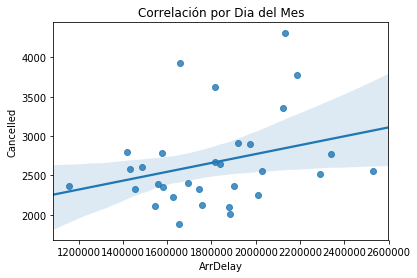

In [41]:

def correlation_by_days():
    res_del = pd.DataFrame()
    res_can = pd.DataFrame()

    for year in years:
        df = df_by_years[year]
        df = df[(df['CancellationCode'] != CSecurity) & (df['CancellationCode'] != CWeather)]
        df1 = df[['DayofMonth', "Cancelled"]]
        df1 = df1.groupby(pd.Grouper(key='DayofMonth')).sum()
        res_can = pd.concat([res_can, df1], sort=False)

        df = df_by_years[year]
        df2 = df[['DayofMonth', "ArrDelay"]]
        df2 = df2.groupby(pd.Grouper(key='DayofMonth')).sum()
        res_del = pd.concat([res_del, df2], sort=False)

    res_del['ArrDelay'] = res_del['ArrDelay'] / len(years*12)
    res_can['Cancelled'] = res_can['Cancelled'] / len(years*12)

    return df1.merge(df2, left_on='DayofMonth', right_on='DayofMonth')

df_by_dom = correlation_by_days()
sns.regplot(x="ArrDelay", y="Cancelled", data=df_by_dom).set_title("Correlación por Dia del Mes")

In [10]:
def plot_lines(periodo):
    for filename in sorted(os.listdir(tmp_dir+periodo)):
        if filename.endswith(".csv") and not filename.endswith("_cancell.csv") and filename not in ["cut.csv"]:
            print(filename)
            df_delay   = pd.read_csv(tmp_dir+periodo+filename)
            df_cancell = pd.read_csv(tmp_dir+periodo+filename.split(".")[0]+"_cancell.csv")

            df_m = df_delay.merge(df_cancell, left_on='date', right_on='date')

            # excluimos el 2001
            df_m = df_m[df_m['date']>'2001/12/31']

            ax = df_m.plot(x="date", y="ArrDelay", legend=False)
            ax2 = ax.twinx()

            df_m.plot(x="date", y="Cancelled", ax=ax2, legend=False, color="r")
            ax.figure.legend()

            xaxis = ax.xaxis.get_major_ticks()
            plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
            plt.tight_layout()

            fig = plt.figure()
            fig.autofmt_xdate()
            plt.show()

plot_lines("monthly/")
plot_lines("daily/")
#Trimestres en verde, cuatrimestres en naranja

1994.csv


TypeError: Empty 'DataFrame': no numeric data to plot

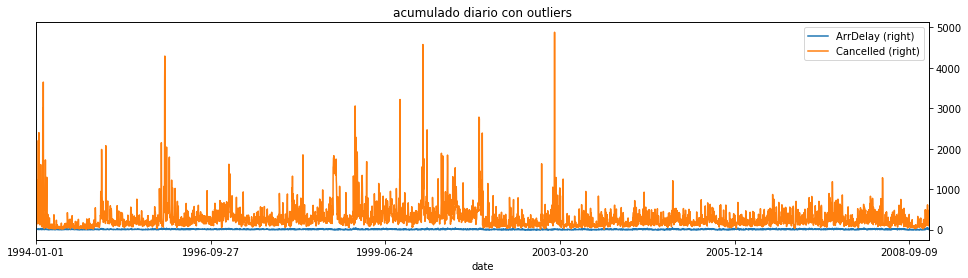

In [11]:
#df_daily_cut = pd.read_csv(tmp_dir+"daily/cut.csv")
#print(df_daily_cut)
#df_daily_cut.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado diario sin outliers")

df_daily_full = pd.read_csv(tmp_dir+"daily/full.csv")
df_daily_cancel_full = pd.read_csv(tmp_dir+"daily/full_cancell.csv")
df_daily_full = df_daily_full.merge(df_daily_cancel_full, left_on='date', right_on='date')
df_daily_full.plot(x="date", y=["ArrDelay", "Cancelled"], secondary_y=True, linestyle='-', figsize=(16,4), title = "acumulado diario con outliers")

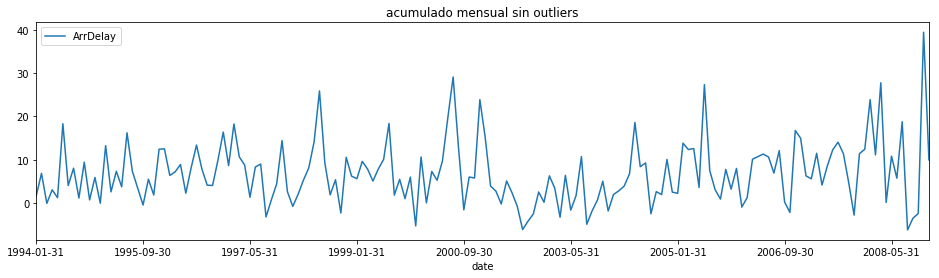

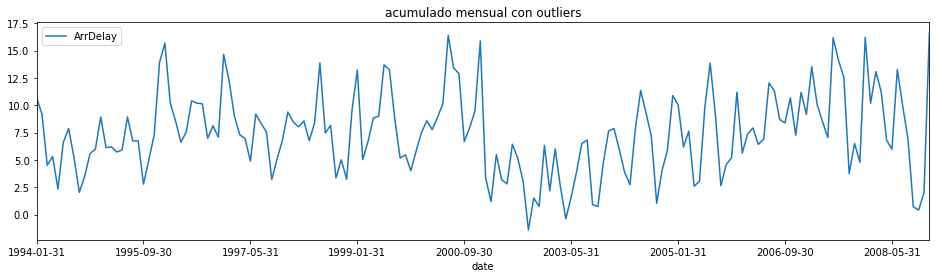

In [12]:
df_monthly_cut = pd.read_csv(tmp_dir+"monthly/cut.csv")
df_monthly_cut.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado mensual sin outliers")

df_monthly_full = pd.read_csv(tmp_dir+"monthly/full.csv")
df_monthly_full.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado mensual con outliers")

# CML acá 
## Diario

In [13]:
#del df

def train_data(fro, to):
    df = pd.read_csv(tmp_dir+"daily/full_cancell.csv")
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.sort_values(by="date")

    train_can = df.loc[(df["date"].dt.year < to) & \
                       (df["date"].dt.year > fro)]["Cancelled"]
    return train_can

year_train_limit = 2004
lower_year_train_limit = 1994

train_can = train_data(lower_year_train_limit, year_train_limit)

print(len(train_can))
print(len(train_can["Cancelled"]))

2922


KeyError: 'Cancelled'

In [14]:
max_grade = 1

phases = [i*math.pi/2 for i in range(4)]
monthly_freqs =  [3, 4, 6, 12]
# semanas, meses, bimestres, trimestres, cuatrimestres, semestres, años
daily_freqs =  [7] + [355/i for i in [12, 6, 4, 3, 2, 1]]

lpr = lsqPredictor(phases, daily_freqs, max_grade)
lpr.fit(train_can)
#lpr.print_coefs()


NameError: name 'math' is not defined

In [15]:
if "dl_pred" in df:
    del df["dl_pred"]

NameError: name 'df' is not defined

In [16]:
train_test_delays = df["Cancelled"]

df["dl_pred"] = lpr.pred(train_test_delays)
df.describe()

NameError: name 'df' is not defined

In [17]:
#df.plot(x="date", y=["DepDelay", "dl_pred"], figsize=(16,5))

def plot_df(df1, df2, train_limit_axis, unit_str):
    plt.figure(figsize=(16,5))
    plt.xlabel('Predicción para el i-ésimo {}'.format(unit_str))

    df2 = df2[df2.index % 30 == 0]
    df1 = df1[df1.index % 30 == 0]

    ax1 = df1.dl_pred.plot(color='orange', grid=True, label='pred delay')
    df2.Cancelled.plot(color='blue', grid=True, secondary_y=False, label='real delay', ax=ax1)

    xticks = ax1.xaxis.get_major_ticks()
    plt.axvline(x=train_limit_axis, color="green")
    plt.show()

df_full = pd.read_csv(tmp_dir+"daily/full_cancell.csv")
df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
plot_df(df, df_full, len(train_delays), "dia")

NameError: name 'df' is not defined

In [18]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(df.loc[df["date"].dt.year>year_train_limit].dl_pred, df_full.loc[df_full["date"].dt.year>year_train_limit].ArrDelay))

NameError: name 'math' is not defined

## Mensual

In [19]:
del df
df = pd.read_csv(tmp_dir+"monthly/full.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.sort_values(by="date")
year_train_limit = 2002
lower_year_train_limit = 1994
train_delays = df.loc[(df["date"].dt.year < year_train_limit) & \
                      (df["date"].dt.year > lower_year_train_limit)]["ArrDelay"]

lpr = lsqPredictor(phases, monthly_freqs, max_grade)
lpr.fit(train_delays)
lpr.print_coefs()

NameError: name 'df' is not defined

In [20]:
if "dl_pred" in df:
    del df["dl_pred"]

NameError: name 'df' is not defined

In [21]:
train_test_delays = df["ArrDelay"]

df["dl_pred"] = lpr.pred(train_test_delays) 

NameError: name 'df' is not defined

In [22]:
df_full = pd.read_csv(tmp_dir+"monthly/full.csv")
df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
plot_df(df, df_full, len(train_delays), "mes")

NameError: name 'df' is not defined

In [23]:
math.sqrt(mean_squared_error(df.loc[df["date"].dt.year>year_train_limit].dl_pred, df_full.loc[df_full["date"].dt.year>year_train_limit].ArrDelay))

NameError: name 'math' is not defined

## BORRAR ARCHIVOS

In [24]:
#borrar aux de años
#for filename in os.listdir(tmp_dir):
#    if fnmatch.fnmatch(filename, '*.csv') and filename != "merged.csv":
#        os.remove(tmp_dir+filename)

In [25]:
#borrar merged
# os.remove(tmp_dir+"merged.csv")

In [26]:
#borrar tmp
#shutil.rmtree(tmp_dir)